In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os


In [2]:
!pip install git+https://github.com/qubvel/segmentation_models

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-qzfm0ee8
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-qzfm0ee8
  Resolved https://github.com/qubvel/segmentation_models to commit 5d24bbfb28af6134e25e2c0b79e7727f6c0491d0
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [3]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

2024-12-31 16:32:38.836350: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-31 16:32:39.302324: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Segmentation Models: using `keras` framework.


'tf.keras'

In [4]:
pip install albumentations==1.2.0


Defaulting to user installation because normal site-packages is not writeable
  Using cached albumentations-1.2.0-py3-none-any.whl (113 kB)
  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)
  Using cached scikit_image-0.18.3-cp310-cp310-linux_x86_64.whl
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.1
    Uninstalling scikit-image-0.19.1:
      Successfully uninstalled scikit-image-0.19.1
Note: you may need to restart the kernel to use updated packages.


In [5]:

from sklearn.model_selection import StratifiedShuffleSplit
import cv2
import albumentations as albu
from skimage.transform import resize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dropout, Dense, GlobalAveragePooling2D
#from keras.optimizers import Adam
import efficientnet.tfkeras as efn
#import efficientnet.keras as efn
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [7]:
bs= 8 # Increase Batch size based on your hardware capacity, if you have powerful GPU try BS=128,256...
train_path=r'archive/Train'
test_path=r'archive/Test'

In [8]:
train_gen=ImageDataGenerator(rescale=1./255, rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
Data_train=train_gen.flow_from_directory(train_path,target_size=(331,331),class_mode='categorical',batch_size=bs)

test_gen=ImageDataGenerator(rescale=1./255)
Data_test=test_gen.flow_from_directory(test_path,target_size=(331,331),class_mode='categorical',batch_size=bs)

Found 9414 images belonging to 200 classes.
Found 2374 images belonging to 200 classes.


In [6]:
#efnb0 = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape=(100,100,3), classes= 200)

#model = Sequential()
#model.add(efnb0)
#model.add(GlobalAveragePooling2D())
#model.add(Dropout(0.5))
#model.add(Dense(200, activation='softmax'))

#model.summary()

In [10]:
from tensorflow.keras.applications import NASNetLarge, EfficientNetB7
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Concatenate

# Load NASNet and EfficientNetB7 with pretrained weights
nasnet = NASNetLarge(weights='imagenet', include_top=False, input_shape=(331, 331, 3))
efnb0 = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(331, 331, 3))

# Freeze layers in both models
nasnet.trainable = False
efnb0.trainable = False

# Input layer
input_layer = Input(shape=(331, 331, 3))

# Pass inputs through both models
nasnet_output = nasnet(input_layer)
efnb0_output = efnb0(input_layer)

# Apply Global Average Pooling to outputs
nasnet_output = GlobalAveragePooling2D()(nasnet_output)
efnb0_output = GlobalAveragePooling2D()(efnb0_output)

# Concatenate the outputs of both models
combined = Concatenate()([nasnet_output, efnb0_output])

# Add Dropout for regularization
combined = Dropout(0.5)(combined)

# Final Dense layer with softmax activation
output_layer = Dense(200, activation='softmax')(combined)

# Create the hybrid model
model = Model(inputs=input_layer, outputs=output_layer)

# Print the model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 NASNet (Functional)            (None, 11, 11, 4032  84916818    ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 efficientnetb7 (Functional)    (None, 11, 11, 2560  64097687    ['input_6[0][0]']                
                                )                                                           

In [11]:
optimizer = Adam(lr=0.0001)

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)
#model compiling
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model_history = model.fit_generator(Data_train, validation_data = Data_test, callbacks = [early_stop, rlrop],verbose = 1, epochs = 50)

#saving the trained model weights as data file in .h5 format
model.save_weights("birds_efficientnetb7_nasnet_weights.h5")

Epoch 1/50


/tmp/ipykernel_912099/1486623065.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(Data_train, validation_data = Data_test, callbacks = [early_stop, rlrop],verbose = 1, epochs = 50)
2024-12-31 16:46:35.170499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-31 16:46:51.593667: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169304064 exceeds 10% of free system memory.
2024-12-31 16:46:51.625299: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169304064 exceeds 10% of free system memory.
2024-12-31 16:46:51.689669: W tensorflow/tsl/framework/cpu_allocator_impl.cc:

   1/1177 [..............................] - ETA: 5:57:48 - loss: 5.4537 - accuracy: 0.0000e+00

2024-12-31 16:46:53.962074: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169304064 exceeds 10% of free system memory.
2024-12-31 16:46:53.997499: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169304064 exceeds 10% of free system memory.


1177/1177 [==============================] - ETA: 0s - loss: 3.2779 - accuracy: 0.2501

2024-12-31 17:35:57.126366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1177/1177 [==============================] - 3690s 3s/step - loss: 3.2779 - accuracy: 0.2501 - val_loss: 2.3281 - val_accuracy: 0.3934 - lr: 0.0010
Epoch 2/50
1177/1177 [==============================] - 3689s 3s/step - loss: 2.2703 - accuracy: 0.4059 - val_loss: 2.0446 - val_accuracy: 0.4537 - lr: 0.0010
Epoch 3/50
1177/1177 [==============================] - 3708s 3s/step - loss: 2.0269 - accuracy: 0.4631 - val_loss: 1.9908 - val_accuracy: 0.4743 - lr: 0.0010
Epoch 4/50
1177/1177 [==============================] - 3685s 3s/step - loss: 1.8535 - accuracy: 0.5093 - val_loss: 1.8218 - val_accuracy: 0.5088 - lr: 0.0010
Epoch 5/50
1177/1177 [==============================] - 3679s 3s/step - loss: 1.7665 - accuracy: 0.5283 - val_loss: 1.8128 - val_accuracy: 0.5168 - lr: 0.0010
Epoch 6/50
1177/1177 [==============================] - 3692s 3s/step - loss: 1.6825 - accuracy: 0.5502 - val_loss: 1.9030 - val_accuracy: 0.5232 - lr: 0.0010
Epoch 7/50
1177/1177 [==============================] - 3

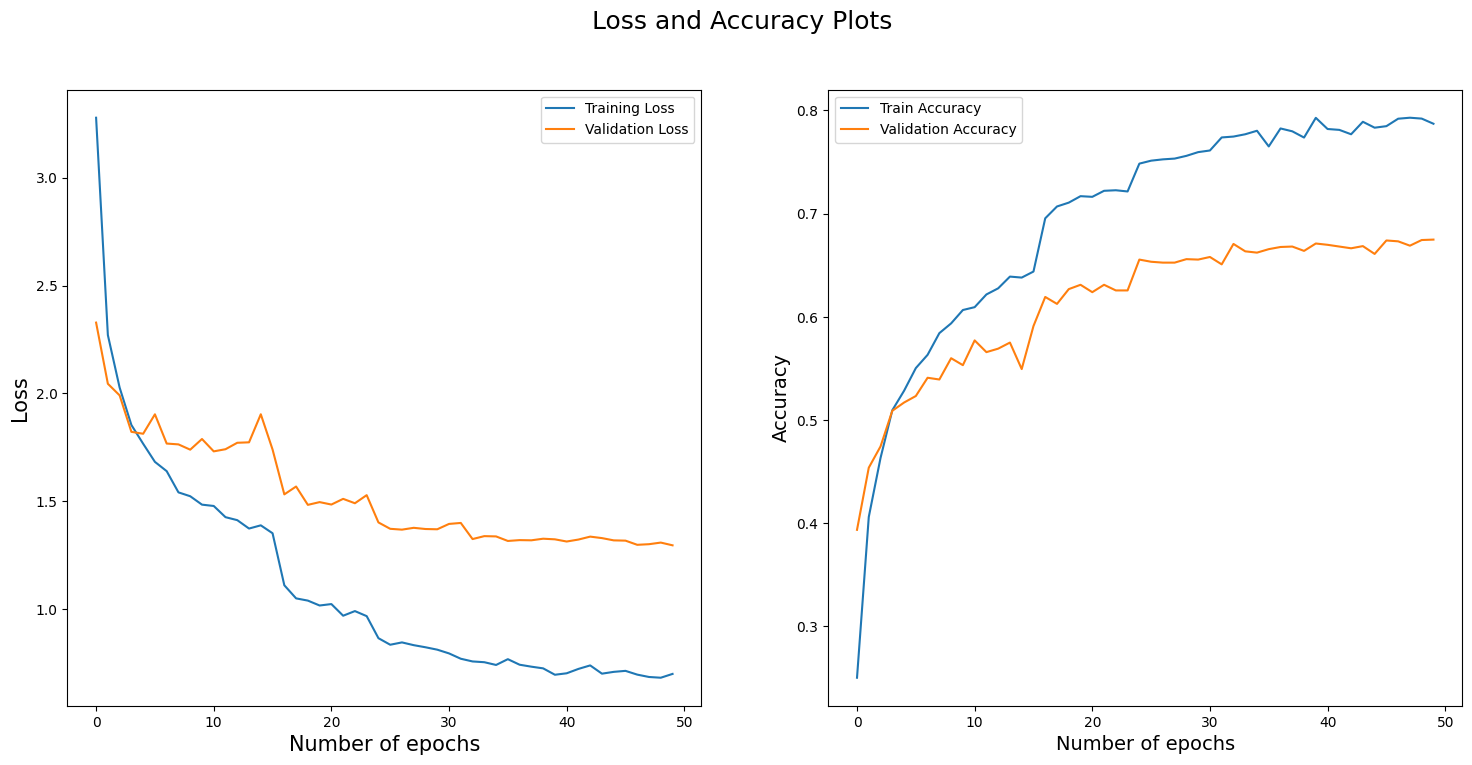

In [13]:
#plot to visualize the loss and accuracy against number of epochs
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

In [16]:

import requests

# Define the file path
file_path = 'birds_efficientnetb7_nasnet_weights.h5'

# Open the file and upload to File.io
with open(file_path, 'rb') as file:
    response = requests.post(
        'https://file.io', 
        files={'file': file}
    )

# Check if the upload was successful and get the download link
if response.status_code == 200:
    download_link = response.json()['link']
    print("File successfully uploaded. Download link:")
    print(download_link)
else:
    print("File upload failed.")

File successfully uploaded. Download link:
https://file.io/I9u9JNwrNTkF


In [17]:
!pip freeze

absl-py==2.1.0
alabaster==0.7.16
albumentations==1.2.0
anyio==4.6.2.post1
apturl==0.5.2
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
astroid==3.2.1
asttokens==2.4.1
astunparse==1.6.3
async-lru==2.0.4
atomicwrites==1.4.1
attrs==23.2.0
autopep8==2.0.4
Babel==2.15.0
bcrypt==3.2.0
beautifulsoup4==4.12.3
binaryornot==0.4.4
black==24.4.2
bleach==6.1.0
blessings==1.7
blinker==1.4
Brlapi==0.8.3
cachetools==5.5.0
certifi==2020.6.20
cffi==1.17.1
chardet==4.0.0
charset-normalizer==3.4.0
click==8.0.3
cloudpickle==3.0.0
colorama==0.4.4
comm==0.2.2
command-not-found==0.3
contourpy==1.3.1
cookiecutter==2.6.0
cryptography==3.4.8
cupshelpers==1.0
cycler==0.12.1
dbus-python==1.2.18
debugpy==1.8.1
decorator==5.1.1
defer==1.0.6
defusedxml==0.7.1
diff-match-patch==20230430
dill==0.3.8
distro==1.7.0
distro-info==1.1+ubuntu0.2
docstring-to-markdown==0.15
docutils==0.21.2
duplicity==0.8.21
editdistance==0.6.0
efficientnet==1.1.1
exceptiongroup==1.2.1
executing==2.0.1
fasteners==0.14.1
fastjso

In [18]:
!python --version

/bin/bash: line 1: python: command not found


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import efficientnet.tfkeras as efn

# Recreate the model architecture
efnb0 = efn.EfficientNetB7(weights=None, include_top=False, input_shape=(100, 100, 3))
model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(200, activation='softmax'))
from tensorflow.keras.applications import NASNetLarge, EfficientNetB7
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Concatenate

# Load NASNet and EfficientNetB7 with pretrained weights
nasnet = NASNetLarge(weights='imagenet', include_top=False, input_shape=(331, 331, 3))
efnb0 = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(331, 331, 3))

# Freeze layers in both models
nasnet.trainable = False
efnb0.trainable = False

# Input layer
input_layer = Input(shape=(331, 331, 3))

# Pass inputs through both models
nasnet_output = nasnet(input_layer)
efnb0_output = efnb0(input_layer)

# Apply Global Average Pooling to outputs
nasnet_output = GlobalAveragePooling2D()(nasnet_output)
efnb0_output = GlobalAveragePooling2D()(efnb0_output)

# Concatenate the outputs of both models
combined = Concatenate()([nasnet_output, efnb0_output])

# Add Dropout for regularization
combined = Dropout(0.5)(combined)

# Final Dense layer with softmax activation
output_layer = Dense(200, activation='softmax')(combined)


# Create the hybrid model
model = Model(inputs=input_layer, outputs=output_layer)

# Load the saved weights
model.load_weights("birds_efficientnetb7_nasnet_weights.h5")


In [24]:
def preprocess_image(image_path):
    # Load the image with target size
    img = load_img(image_path, target_size=(331, 331))
    # Convert image to array
    img_array = img_to_array(img)
    # Rescale pixel values
    img_array = img_array / 255.0
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


In [25]:
def predict_image(image_path):
    processed_image = preprocess_image(image_path)
    predictions = model.predict(processed_image)
    predicted_class = np.argmax(predictions, axis=1)  # Get the index of the highest probability
    return predicted_class, predictions


In [26]:
image_path = "archive/Train/Artic_Tern/Artic_Tern_0011_143355.jpg"
predicted_class, probabilities = predict_image(image_path)

print(f"Predicted Class: {predicted_class[0]}")
print(f"Class Probabilities: {probabilities}")


1/1 [==============================] - 5s 5s/step
Predicted Class: 7
Class Probabilities: [[1.57613972e-16 5.02264491e-15 7.30548630e-21 7.19651321e-19
  4.86659823e-20 1.14591064e-16 5.52294433e-17 7.52157986e-01
  7.52289169e-18 6.08813492e-18 2.20598522e-11 1.18022443e-12
  9.10105388e-21 1.46525514e-10 3.53210928e-21 1.17787622e-05
  1.07640837e-18 2.23215459e-15 8.43388493e-19 6.88632099e-19
  1.68739791e-19 5.99134362e-19 3.85362889e-21 1.61151674e-17
  3.22260359e-14 5.95197965e-19 5.76819666e-19 3.81136909e-18
  3.83090087e-11 2.80768789e-13 6.76458180e-17 2.30369387e-17
  9.69738212e-20 2.15329010e-18 6.84363434e-19 2.43699962e-20
  1.65180369e-18 5.87319164e-06 5.51142915e-18 2.22810068e-19
  1.62859493e-21 1.77158016e-17 4.98702112e-22 2.15839734e-03
  1.33775892e-17 9.58873801e-16 1.33303319e-22 1.97323470e-19
  6.99947624e-15 2.07558429e-10 4.48092656e-20 6.37205336e-14
  3.37974186e-17 6.66125305e-03 1.77420649e-22 1.04729176e-15
  2.56752338e-19 1.63377208e-21 9.06388326

In [27]:
class_indices = Data_train.class_indices  # This provides a dictionary {class_name: index}
index_to_class = {v: k for k, v in class_indices.items()}  # Reverse mapping

predicted_class_name = index_to_class[predicted_class[0]]
print(f"Predicted Class Name: {predicted_class_name}")


Predicted Class Name: Artic_Tern


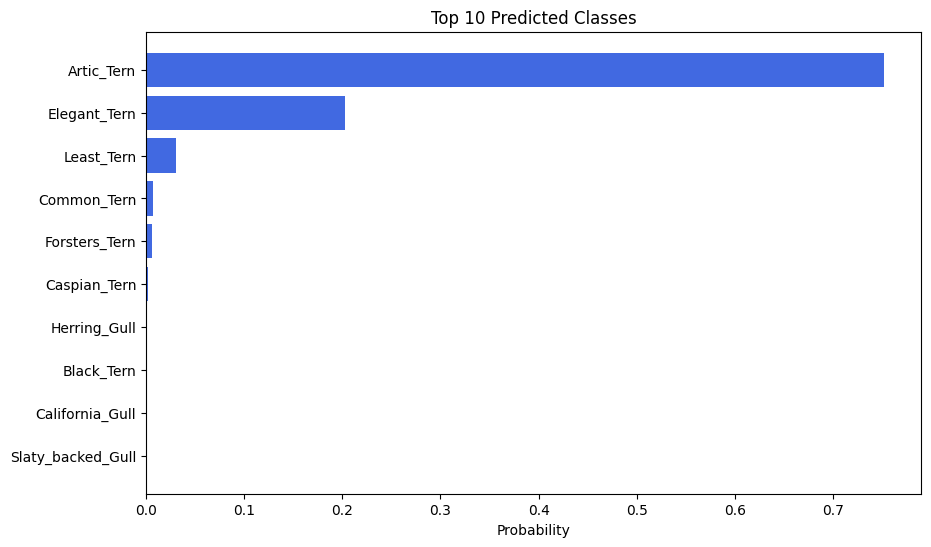

In [59]:
import numpy as np
import matplotlib.pyplot as plt

def plot_enhanced_probability_heatmap(probabilities, class_names):
    # If probabilities is a single prediction, reshape it into a 2D array
    if probabilities.ndim == 1:
        probabilities = np.expand_dims(probabilities, axis=0)

    # For each sample, plot the top 10 probabilities
    for prob in probabilities:
        top_indices = np.argsort(prob)[-10:]  # Top 10 probabilities
        top_probabilities = prob[top_indices]
        top_class_names = [class_names[i] for i in top_indices]

        # Plot heatmap
        plt.figure(figsize=(10, 6))
        plt.barh(top_class_names, top_probabilities, color='royalblue')
        plt.xlabel('Probability')
        plt.title('Top 10 Predicted Classes')
        plt.show()

# Example usage
class_names = list(Data_train.class_indices.keys())  # Your class labels
plot_enhanced_probability_heatmap(probabilities, class_names)


In [28]:
class_indices

{'Acadian_Flycatcher': 0,
 'American_Crow': 1,
 'American_Goldfinch': 2,
 'American_Pipit': 3,
 'American_Redstart': 4,
 'American_Three_toed_Woodpecker': 5,
 'Anna_Hummingbird': 6,
 'Artic_Tern': 7,
 'Baird_Sparrow': 8,
 'Baltimore_Oriole': 9,
 'Bank_Swallow': 10,
 'Barn_Swallow': 11,
 'Bay_breasted_Warbler': 12,
 'Belted_Kingfisher': 13,
 'Bewick_Wren': 14,
 'Black_Tern': 15,
 'Black_and_white_Warbler': 16,
 'Black_billed_Cuckoo': 17,
 'Black_capped_Vireo': 18,
 'Black_footed_Albatross': 19,
 'Black_throated_Blue_Warbler': 20,
 'Black_throated_Sparrow': 21,
 'Blue_Grosbeak': 22,
 'Blue_Jay': 23,
 'Blue_headed_Vireo': 24,
 'Blue_winged_Warbler': 25,
 'Boat_tailed_Grackle': 26,
 'Bobolink': 27,
 'Bohemian_Waxwing': 28,
 'Brandt_Cormorant': 29,
 'Brewer_Blackbird': 30,
 'Brewer_Sparrow': 31,
 'Bronzed_Cowbird': 32,
 'Brown_Creeper': 33,
 'Brown_Pelican': 34,
 'Brown_Thrasher': 35,
 'Cactus_Wren': 36,
 'California_Gull': 37,
 'Canada_Warbler': 38,
 'Cape_Glossy_Starling': 39,
 'Cape_May_

1/1 [==============================] - 2s 2s/step


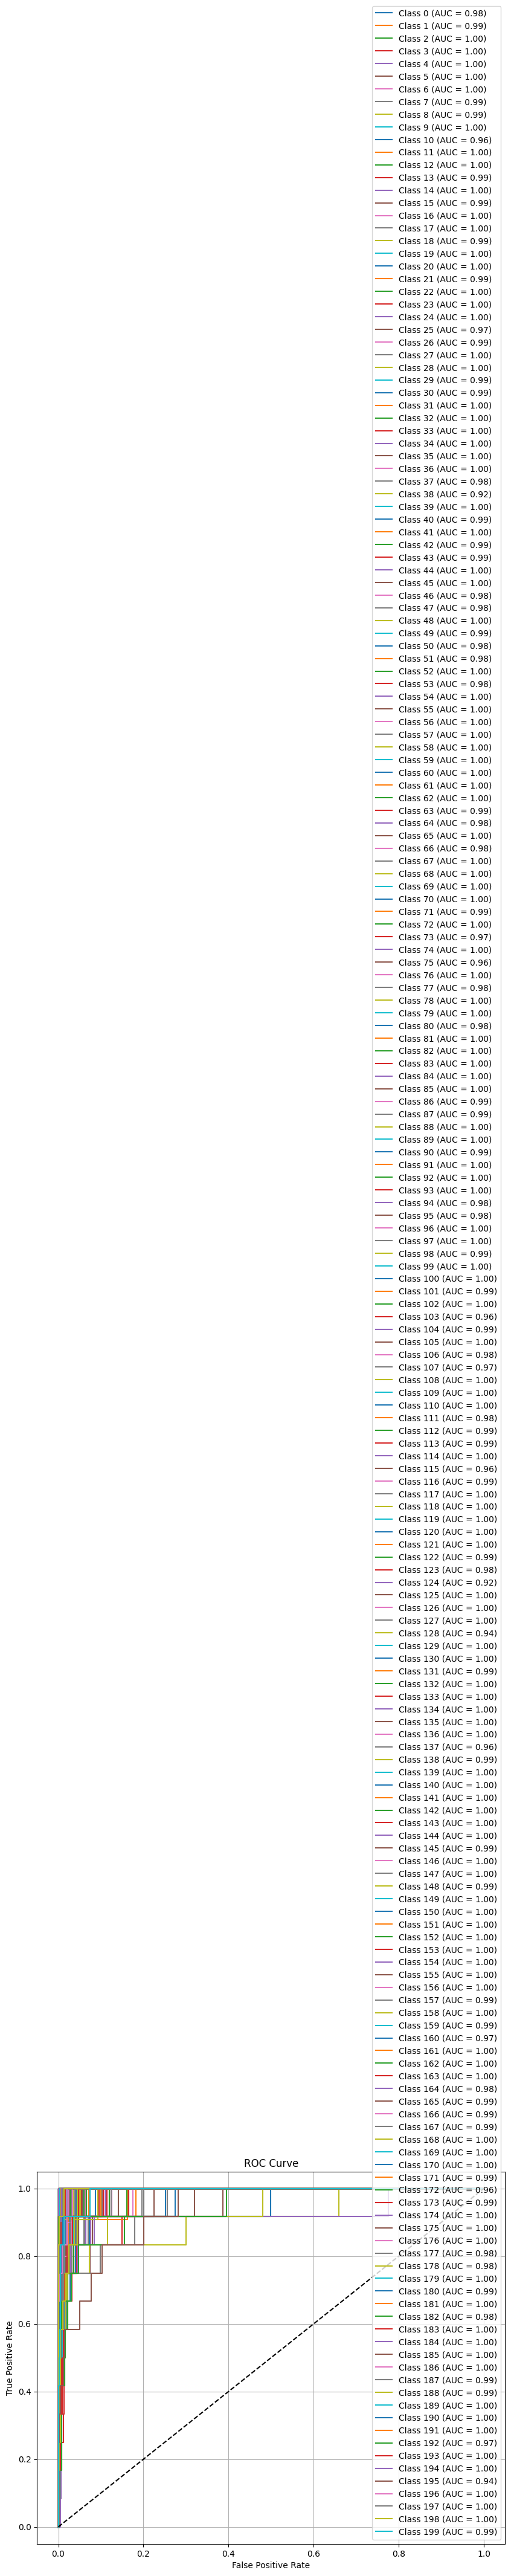

In [35]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Get true labels and predicted probabilities
true_labels = []
predicted_probs = []

for i in range(len(Data_test)):
    x, y = Data_test[i]
    true_labels.extend(y)  # Append true labels
    predicted_probs.extend(model.predict(x))  # Append predictions

# Convert lists to arrays
true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

# Binarize the true labels (one-hot encoding)
num_classes = true_labels.shape[1]
true_labels_binarized = label_binarize(true_labels.argmax(axis=1), classes=range(num_classes))

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_labels_binarized[:, i], predicted_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

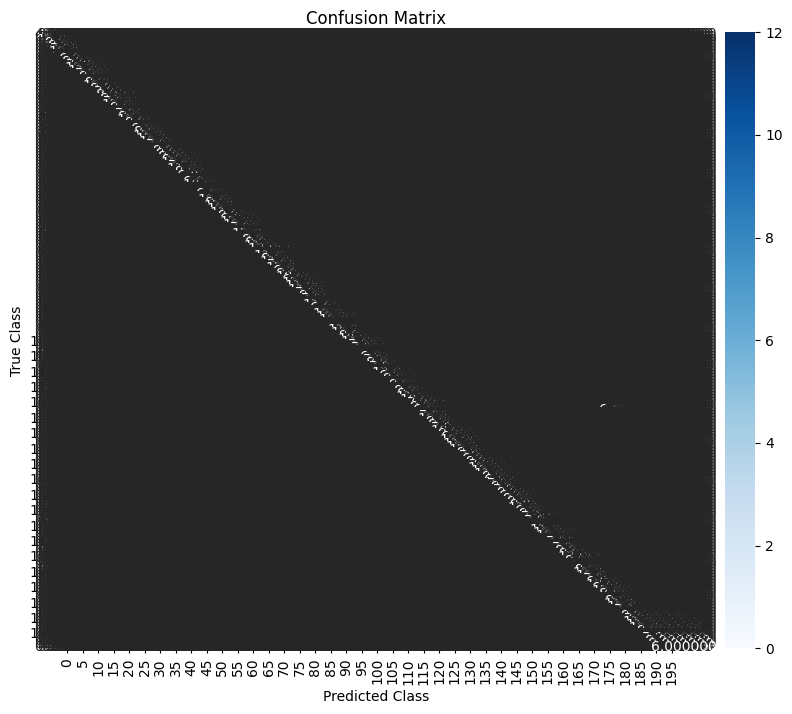

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'predicted_probs' is a NumPy array of shape (number_of_samples, number_of_classes)
# and 'true_labels' is a NumPy array of shape (number_of_samples, number_of_classes)
# with one-hot encoded labels.

# Create a confusion matrix
confusion_matrix = np.zeros((num_classes, num_classes))
for i in range(len(true_labels)):
    true_class = np.argmax(true_labels[i])
    predicted_class = np.argmax(predicted_probs[i])
    confusion_matrix[true_class, predicted_class] += 1

# Create a DataFrame from the confusion matrix
df_cm = pd.DataFrame(confusion_matrix, index=range(num_classes), columns=range(num_classes))

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt='f', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

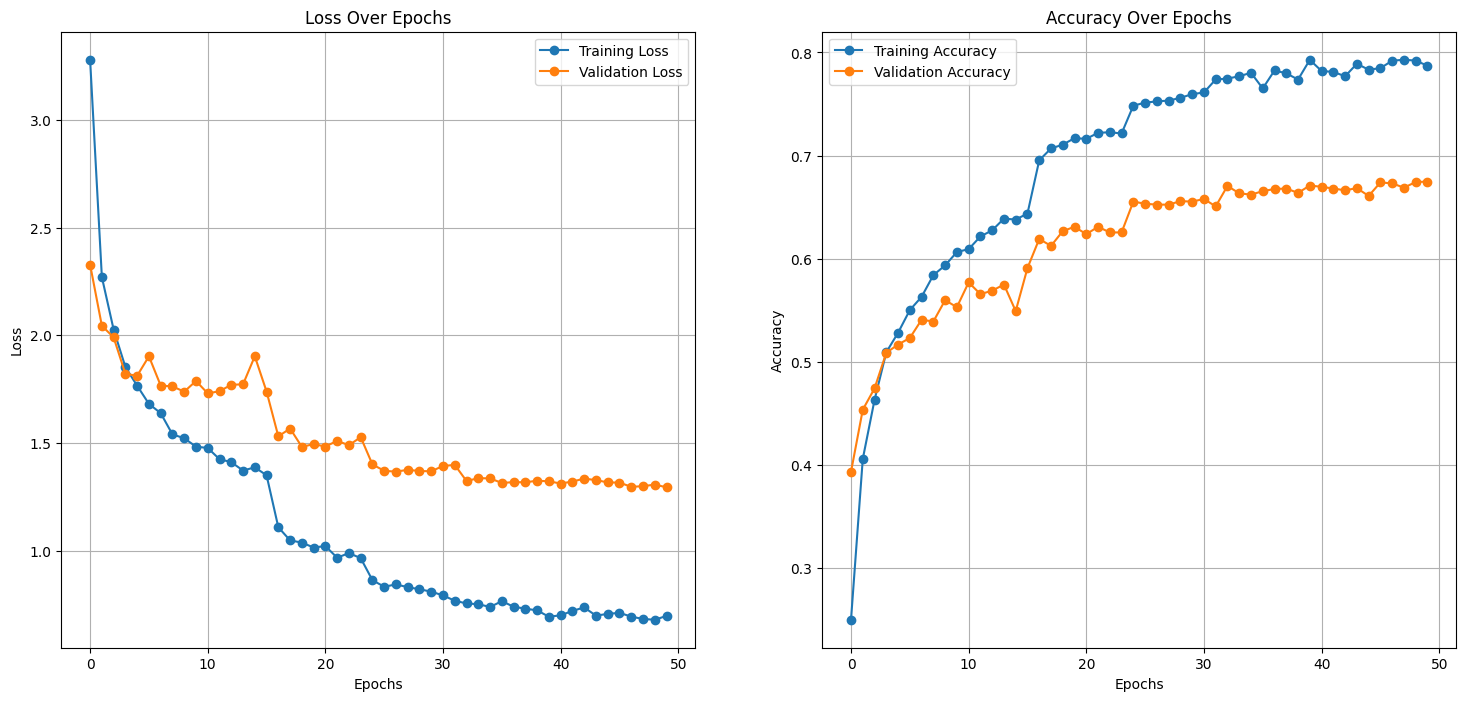

In [50]:
def plot_training_history(history):
    plt.figure(figsize=(18, 8))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title("Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.show()

# Example usage
plot_training_history(model_history)


1/1 [==============================] - 0s 284ms/step


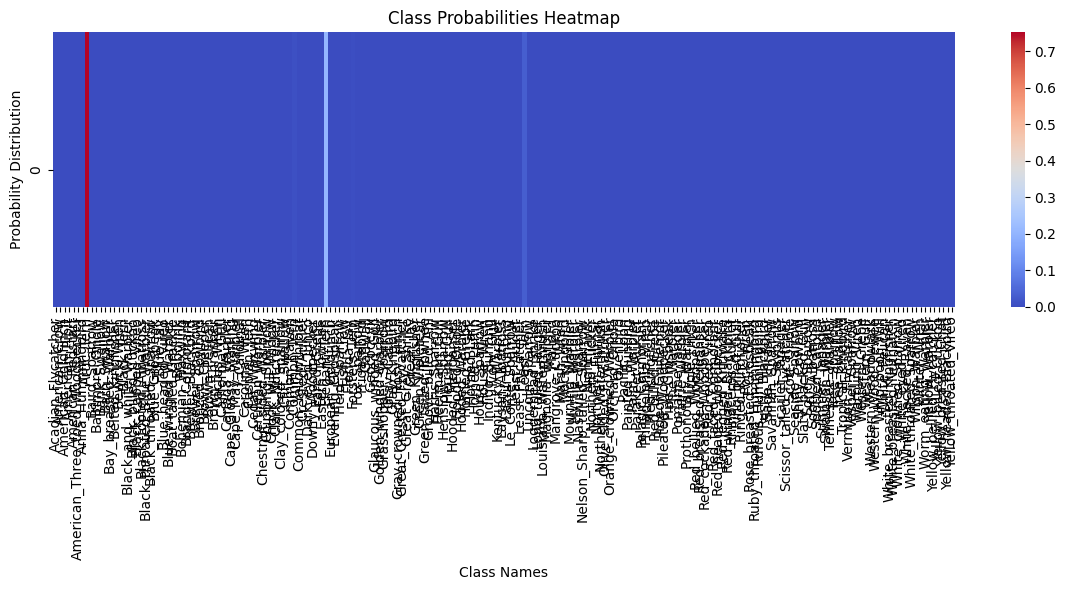

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_probability_heatmap(image_path):
    # Preprocess the image
    processed_image = preprocess_image(image_path)
    # Get predicted probabilities
    probabilities = model.predict(processed_image)[0]
    
    # Convert class indices to class names
    class_names = list(Data_train.class_indices.keys())
    
    # Plot heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap([probabilities], annot=False, cmap="coolwarm", xticklabels=class_names)
    plt.title("Class Probabilities Heatmap")
    plt.xlabel("Class Names")
    plt.ylabel("Probability Distribution")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Example usage
image_path = "archive/Train/Artic_Tern/Artic_Tern_0011_143355.jpg"
plot_probability_heatmap(image_path)


1/1 [==============================] - 0s 24ms/step
Feature map shape: (165, 165, 96)


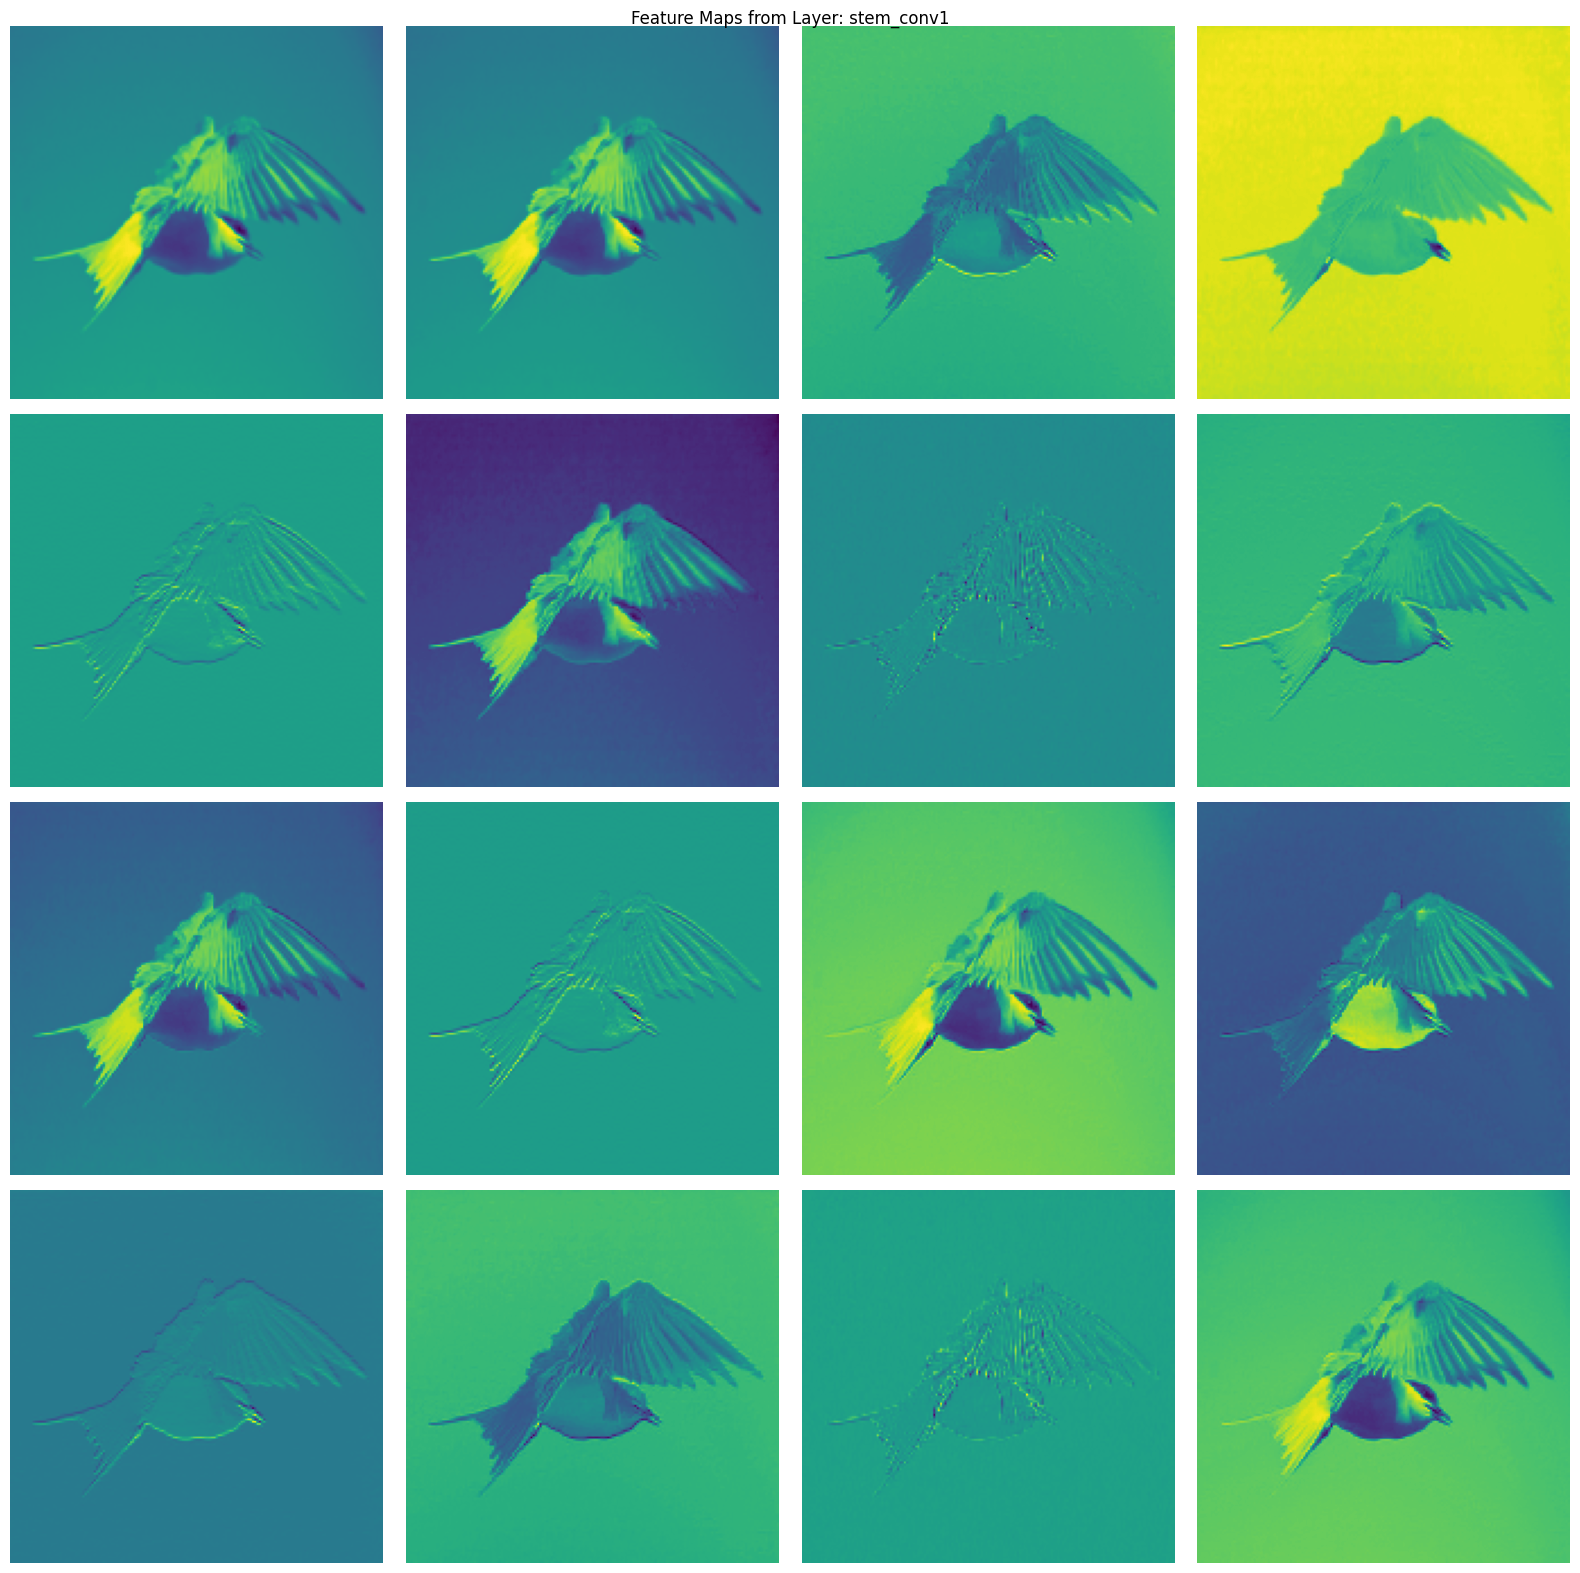

In [56]:
from tensorflow.keras.models import Model
import numpy as np

def plot_feature_map_heatmap(image_path, submodel, layer_name):
    # Preprocess the image
    processed_image = preprocess_image(image_path)
    
    # Create a model for intermediate output
    intermediate_model = Model(inputs=submodel.input, outputs=submodel.get_layer(layer_name).output)
    
    # Get feature map
    feature_map = intermediate_model.predict(processed_image)[0]
    
    # Check dimensions of the feature map
    print(f"Feature map shape: {feature_map.shape}")
    
    # Plot heatmaps for the feature maps
    num_features = feature_map.shape[-1]
    plt.figure(figsize=(16, 16))
    for i in range(min(num_features, 16)):  # Display the first 16 feature maps
        plt.subplot(4, 4, i + 1)
        plt.imshow(feature_map[:, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f"Feature Maps from Layer: {layer_name}")
    plt.tight_layout()
    plt.show()

# Example usage with the NASNet submodel and the `stem_conv1` layer
layer_name = "stem_conv1"  # A valid convolutional layer name
plot_feature_map_heatmap(image_path, nasnet, layer_name)


In [64]:
print("Processing .........")

Processing .........


In [ ]:
print("Done  ")